In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.font_manager
from scipy import stats

from scripts import preprocessing as sprocessing
from scripts import clockface_plots as sclockface
from scripts import heatmap_plots as sheatmap
from scripts import config as sconfig
from scripts import utils as sutils
from scripts import dataloaders as sdataloaders
from scripts import similarity_processor as ssimilarity
from scripts import constants as sconstants
from scripts import day_night_comparisons as sday
from scripts.path_utils import *
from scripts.enums import Columns, FactTypes, ContentType, Clusters

# Loading and preprocessing

In [2]:
np.random.seed(0)
config = sconfig.Config(date_from = '2020-01-22')
dl = sdataloaders.APILoader(config)
country_config = sconfig.CountryConfig(LABEL='ITA', TIME_ZONE='Europe/Rome')
processor = sprocessing.DataProcessor(config)
processor.load_and_prepare(dl, country_config)

ITA in store from 2020-01-22 to 2022-08-01. Store contains ['/ALL', '/DEU', '/ITA', '/ITA_preprocessed', '/NONE'].
Getting DF from Store for the dates 2020-01-22 to 2022-08-01
where_clause:  Datetime >= start_date & Datetime < end_date 
Completed loading DF of size  (18846723, 9)
Converting dateTime
Converting  Columns.YEAR
Converting  Columns.MONTH
Converting  Columns.MIN_BINS15
Finding posts per user


In [3]:
from scripts.path_utils import *
TYPE='unverified'
activity_path_manager = ActivityPathManager(config, country_config.LABEL, TYPE)
ratio_path_manager = MachinatedPathManager(config, country_config.LABEL, TYPE)

In [4]:
unverified_mask = ~processor.all[Columns.VERIFIED.value]
known_mask = processor.all[Columns.FACTTYPE.value]!=FactTypes.OTHER.value.name

In [5]:
all_col = pd.read_parquet(get_cluster_col_path(activity_path_manager))
processor.all[Columns.CLUSTER.value] = all_col

In [6]:
no_bots_mask = processor.all[Columns.CLUSTER.value] != Clusters.BOT.value
type_mask = no_bots_mask & unverified_mask

In [7]:
import pickle
with open(get_waking_time_path(config, country_config, TYPE), 'rb') as f:
    waking_times = pickle.load(f)

In [8]:
activity_col=Columns.ACTIVITY_WEIGHTED.value
ratio_col=Columns.RATIO_BY_USER.value

In [27]:
activity = activity_path_manager.load('signal')
ratio = ratio_path_manager.load('signal')
activity_smoothed = activity_path_manager.load('fourier')
ratio_smoothed = ratio_path_manager.load('fourier')

# Corpus, general

Tweets were collected based on keywords and hashtags related to Covid (as described in Gallotti2020). In the following, we only look at Tweets that were classified with a FactType, meaning that they contain a URL in one of the domains in the database by Gallotti2020.
We assume that circadian rhythms have a similar effect on tweets with and without URLS.

In [13]:
pd.crosstab(processor.all[Columns.VERIFIED.value], processor.all[Columns.IS_BOT.value], margins=True, dropna=False, normalize=True)

isBot,False,True,All
verified,,,
False,0.547728,0.432514,0.980242
True,0.003867,0.015891,0.019758
All,0.551595,0.448405,1.000000


In [14]:
def get_facttype_stats(df):
    aggr_dict = {Columns.TWEET_ID.value: 'count', Columns.NUM_POSTS.value: ('mean', 'median')}
    facttype_stats= df.groupby(Columns.FACTTYPE.value).agg(aggr_dict)
    facttype_stats = facttype_stats.loc[list(sconstants.FACTTYPE_NAME_MAP.keys())].rename(sconstants.FACTTYPE_MAP, axis=0)
    facttype_stats.loc[ContentType.MANIPULATED.value]=df.groupby(Columns.MACHINATED.value).agg(aggr_dict).loc[True].values
    facttype_stats.columns=['total posts', 'mean posts per author', 'median posts per author']
    facttype_stats.index.name= ''
    return facttype_stats

In [15]:
facttype_stats = get_facttype_stats(processor.all.loc[type_mask])
activity_path_manager.to_latex(facttype_stats.style.format('{:.0f}'), "fact_type_stats.tex", "Statistics for each content type.")
facttype_stats

,total posts,mean posts per author,median posts per author
,,,
Science,18597.0,2274.796903,483.0
Mainstream Media,719196.0,2226.938091,589.0
Satire,4289.0,732.678946,169.0
Clickbait,12189.0,734.593568,39.0
Other,16829168.0,1733.080469,351.0
Political,98202.0,2764.273497,721.0
Fake or hoax,43716.0,2608.586559,1150.5
Conspiracy or junk science,65556.0,4281.094560,1679.0
potentially machinated,207474.0,3210.742507,1119.0


# Inter-cluster variation
## Correlation of user activity with ratio of potentially machinated content

In [16]:
spearman_df = pd.DataFrame(index=list(Clusters), columns=pd.MultiIndex.from_product((
    ['Posts per user', 'Activity per day', 'Fourier smoothed activity per day'],  ['Rho', 'P-Value'])))

by_num_posts_harmful_cluster = sprocessing.group_by_with_total(
    processor.all.loc[type_mask & known_mask],
    group_by_cols=[Columns.NUM_POSTS, Columns.MACHINATED, Columns.CLUSTER],
    ratio_for_idx=-2
).xs(True, level=Columns.MACHINATED.value)[ratio_col]

In [17]:
for c in list(Clusters) + ['total']:
    rho_t ,p_t = stats.spearmanr((t:=by_num_posts_harmful_cluster.xs(c, level=Columns.CLUSTER.value)).index, t.values)
    rho_ar, p_ar = stats.spearmanr(
        activity.xs(c, level=Columns.CLUSTER.value)[activity_col],
        ratio.xs(c, level=Columns.CLUSTER.value)[ratio_col])
    rho_ar_smoothed, p_ar_smoothed = stats.spearmanr(
        activity_smoothed.xs(c, level=Columns.CLUSTER.value)[activity_col],
        ratio_smoothed.xs(c, level=Columns.CLUSTER.value)[ratio_col])
    spearman_df.loc[c] = rho_t, p_t, rho_ar, p_ar, rho_ar_smoothed, p_ar_smoothed


In [18]:
spearman_df

Posts per user           Activity per day            \
                             Rho   P-Value              Rho   P-Value   
infrequent type         0.186112   0.00381        -0.309794   0.00213   
morning type            0.195636       0.0        -0.518204       0.0   
intermediate type      -0.064788  0.135965        -0.121283  0.239151   
evening type            0.160237       0.0         0.135513  0.188027   
total                   0.199507       0.0        -0.307868  0.002277   

                  Fourier smoothed activity per day            
                                                Rho   P-Value  
infrequent type                           -0.495578       0.0  
morning type                              -0.756633       0.0  
intermediate type                         -0.136028  0.186338  
evening type                               0.010431  0.919654  
total                                     -0.495212       0.0

In [19]:
activity_path_manager.to_latex(
    spearman_df
    .style
    .format(
        {(c,r):f for r,f in zip(
            ['Rho', 'P-Value'],
            [lambda x: f'{x:.3f}', lambda x: f'{x:.1e}'])
         for c in spearman_df.columns.unique(level=0)})
    .applymap(
        lambda v: 'font-weight: bold;' if (v <0.05)  else None,
        subset=pd.IndexSlice[:, pd.IndexSlice[:, "P-Value"]]
    ),
    'spearman_harmful_activity',
    r"Spearman correlation and corresponding p-value comparing a cluster's total activity as well as activity level throughout the day with the ratio of harmful content spread, including politically biased information, fake or hoax news, and conspiracy or junk science.",
    is_multi_index=True
)

## Distances by curve features

If we assume that each chronotype follows similar behavioral patterns but with a time delay depending on their wake-up time, we should see that the curve of their susceptibility over time approaches that of other clusters when aligning the curves by similarity.

We have a few options for aligning by similarity:

We may align by what we estimate is the wake-up time. While we cannot infer the wake-up time per se, we can infer the time when users are usually not asleep, as they are active on Twitter. Therefore, we can estimate that the nadir of their activity is when they are fast asleep.
We consider the user to be asleep within the 8 consecutive hours that they are least active during the day.

Other options are
- the first inflection after the minimum activity (when the slope changes starts getting shallower)
- the first peak after the minimum activity
- the steepest ascent.


## Content types

Do content types differ significantly between clusters?

In [20]:
sp =ssimilarity.SimilarityProcessor(
    activity,
    c_col=Columns.CLUSTER.value,
    a_col=activity_col,
    cluster_order=list(Clusters),
    waking_times=waking_times
)
sp.prep()

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


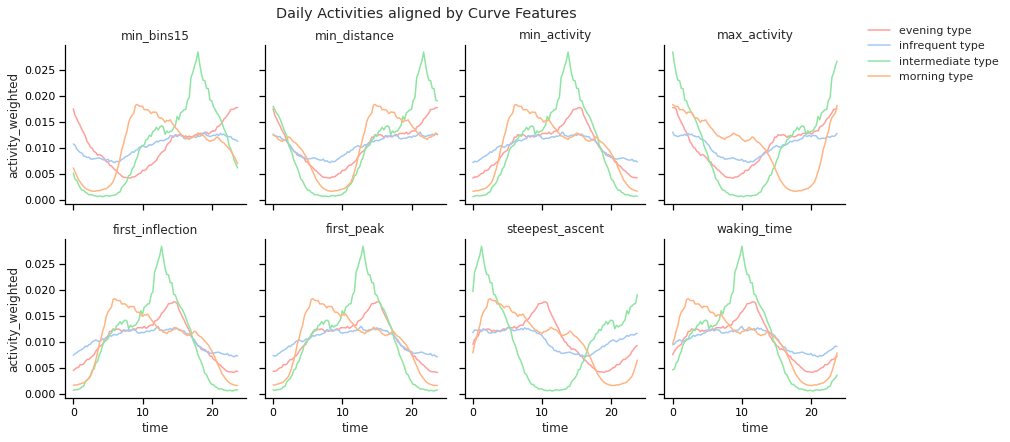

In [21]:
ssimilarity.plot_daily_activities(sp.activity, sp.c_col, y_col=activity_col, palette=Clusters.palette(), col_wrap=4, height=3,
                                  alignment_list=ssimilarity.ALIGNMNENT_LIST+['waking_time'])

In [22]:
sp.similarities.xs('features', level=0).style.highlight_min(props="font-weight: bold;", axis=0).format('{:e}')

,pcm,frechet,area_between_two_curves,curve_length_measure,dtw,mae,mse
min_bins15,1.399064e+01,1.218124e-02,1.150304e-01,4.839954e+00,4.700354e-01,2.448101e-03,1.942854e-05
min_activity,1.624811e+01,1.419928e-02,1.593992e-01,5.144088e+00,6.404713e-01,3.335788e-03,3.320756e-05
max_activity,2.119695e+01,1.334072e-02,1.409458e-01,4.417831e+00,5.721740e-01,2.980073e-03,2.769574e-05
first_inflection,1.587299e+01,1.403767e-02,1.580768e-01,5.075254e+00,6.364045e-01,3.314607e-03,3.244701e-05
first_peak,1.582102e+01,1.411200e-02,1.570529e-01,5.081719e+00,6.321535e-01,3.292466e-03,3.242025e-05
steepest_ascent,1.836509e+01,1.150220e-02,1.041594e-01,3.826803e+00,4.212354e-01,2.193934e-03,1.684442e-05
waking_time,2.187833e+01,1.432042e-02,1.603984e-01,5.127890e+00,6.479270e-01,3.374620e-03,3.376309e-05


In [23]:
## sanity check - the diagonal needs to be minimised (except majority)
sp.similarities.xs('distance metrics', level=0).style.highlight_min(color="lightblue", axis=0).format('{:e}')

,pcm,frechet,area_between_two_curves,curve_length_measure,dtw,mae,mse
pcm,8.927777e+00,9.725748e-03,7.602982e-02,3.459719e+00,3.072881e-01,1.600459e-03,8.194434e-06
frechet,1.064251e+01,7.308109e-03,7.016941e-02,3.044994e+00,2.865115e-01,1.492247e-03,6.364613e-06
area_between_two_curves,1.078392e+01,8.114725e-03,6.290246e-02,3.603809e+00,2.552897e-01,1.329634e-03,5.698459e-06
curve_length_measure,9.404109e+00,8.795190e-03,7.913261e-02,2.769850e+00,3.223666e-01,1.678993e-03,8.782122e-06
dtw,1.078392e+01,8.114725e-03,6.290246e-02,3.603809e+00,2.552897e-01,1.329634e-03,5.698459e-06
mae,1.078392e+01,8.114725e-03,6.290246e-02,3.603809e+00,2.552897e-01,1.329634e-03,5.698459e-06
mse,1.080807e+01,7.694137e-03,6.434760e-02,3.333885e+00,2.619763e-01,1.364460e-03,5.470746e-06
majority,1.078392e+01,8.114725e-03,6.290246e-02,3.603809e+00,2.552897e-01,1.329634e-03,5.698459e-06


In [24]:
sp.shift_by.style.applymap(lambda _: 'font-weight: bold', subset=pd.IndexSlice[:, 'majority']).format('{:.2f}')

,pcm,frechet,area_between_two_curves,curve_length_measure,dtw,mae,mse,majority
cluster,,,,,,,,
evening type,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
infrequent type,-4.25,-4.75,-2.25,-3.50,-2.25,-2.25,-2.75,-2.25
intermediate type,-3.25,-5.50,-3.75,-5.75,-3.75,-3.75,-4.50,-3.75
morning type,-9.25,-5.75,-5.50,-9.75,-5.50,-5.50,-5.75,-5.50


In [25]:
hsp = ssimilarity.ColSimilarityProcessor(sp, ratio, ContentType.palette(), [True, False], i_col=ratio_col)
hsp.prep()

In [26]:
hsp.ratio_similarities.loc['features'].style.highlight_min(color="lightblue", axis=0).format('{:e}')

,pcm,frechet,area_between_two_curves,curve_length_measure,dtw,mae,mse
min_bins15,4.764666e+01,2.225741e-01,2.760931e+00,3.880020e+00,1.116844e+01,5.816896e-02,7.768963e-03
min_activity,4.187803e+01,2.322842e-01,2.774670e+00,3.564903e+00,1.119723e+01,5.831889e-02,8.073830e-03
max_activity,3.161865e+01,2.268275e-01,2.778112e+00,3.862890e+00,1.123172e+01,5.849856e-02,8.233015e-03
first_inflection,4.082522e+01,2.286009e-01,2.777644e+00,3.568711e+00,1.121058e+01,5.838841e-02,8.070467e-03
first_peak,4.135423e+01,2.343473e-01,2.764852e+00,3.537957e+00,1.119095e+01,5.828621e-02,8.028067e-03
steepest_ascent,3.055988e+01,2.182326e-01,2.758291e+00,3.769797e+00,1.115504e+01,5.809916e-02,7.699309e-03
waking_time,3.849793e+01,2.361463e-01,2.774450e+00,3.532663e+00,1.119286e+01,5.829616e-02,8.110201e-03


### Smoothed

In [27]:
activity_smoothed.index.names=['min_bins15', 'cluster']

In [28]:
sp = ssimilarity.SimilarityProcessor(
    activity_smoothed,
    c_col=Columns.CLUSTER.value,
    a_col=activity_col,
    cluster_order=list(Clusters),
    waking_times=waking_times
)
sp.prep()

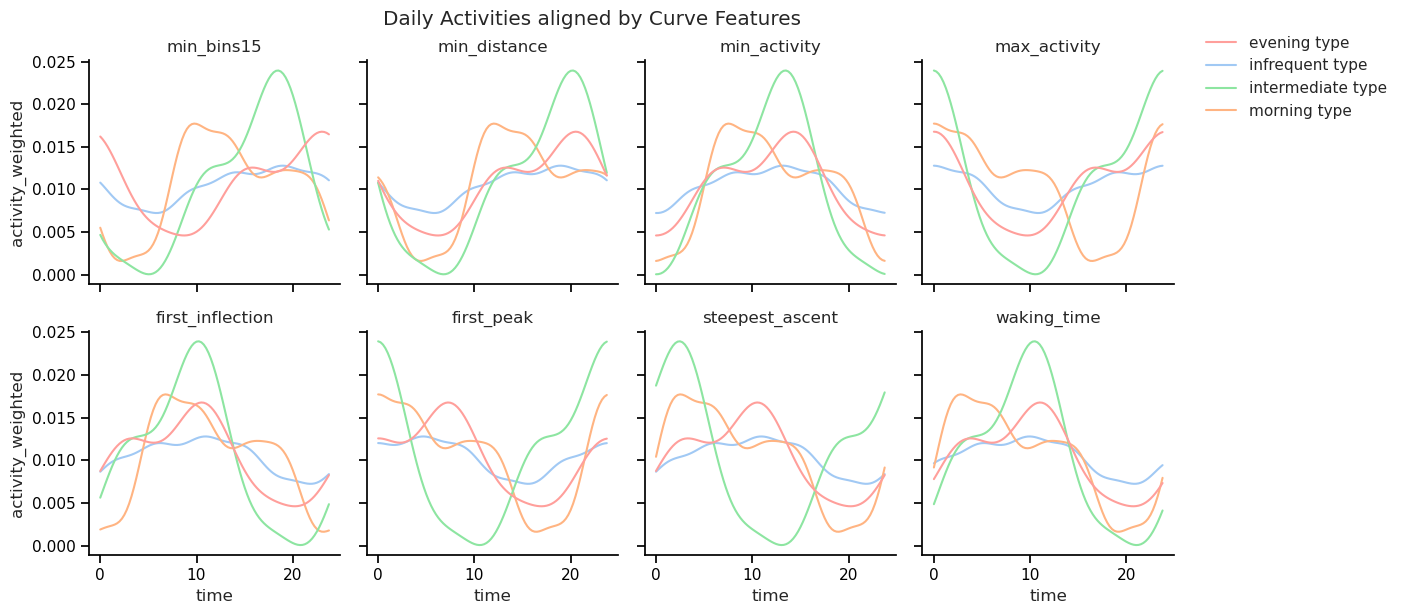

In [29]:
ssimilarity.plot_daily_activities(sp.activity, sp.c_col, y_col=activity_col, palette=Clusters.palette(), col_wrap=4,
                                  height=3,
                                  alignment_list=ssimilarity.ALIGNMNENT_LIST + ['waking_time'])

In [30]:
sp.similarities.xs('features', level=0).style.highlight_min(props="font-weight: bold;", axis=0).format('{:e}')

,pcm,frechet,area_between_two_curves,curve_length_measure,dtw,mae,mse
min_bins15,2.739788e+01,8.103374e-03,8.964949e-02,3.504412e+00,3.640451e-01,1.896068e-03,1.111119e-05
min_activity,3.541407e+01,1.018349e-02,1.108876e-01,3.666951e+00,4.476745e-01,2.331638e-03,1.635107e-05
max_activity,4.913532e+01,1.031553e-02,1.196962e-01,4.369667e+00,4.862125e-01,2.532357e-03,1.799269e-05
first_inflection,3.867594e+01,1.025764e-02,1.171944e-01,4.054524e+00,4.724807e-01,2.460837e-03,1.781171e-05
first_peak,4.317171e+01,9.964860e-03,1.106184e-01,3.861970e+00,4.492340e-01,2.339760e-03,1.732950e-05
steepest_ascent,5.027939e+01,1.104570e-02,1.208843e-01,4.135249e+00,4.877994e-01,2.540622e-03,2.046936e-05
waking_time,3.605846e+01,9.940576e-03,1.070526e-01,3.762040e+00,4.319787e-01,2.249889e-03,1.517694e-05


In [31]:
## sanity check - the diagonal needs to be minimised (except majority)
sp.similarities.xs('distance metrics', level=0).style.highlight_min(color="lightblue", axis=0).format('{:e}')

,pcm,frechet,area_between_two_curves,curve_length_measure,dtw,mae,mse
pcm,2.451874e+01,7.621693e-03,8.496700e-02,3.612208e+00,3.440919e-01,1.792145e-03,1.022374e-05
frechet,2.617389e+01,7.091087e-03,8.199745e-02,3.561087e+00,3.308385e-01,1.723117e-03,9.372601e-06
area_between_two_curves,2.957021e+01,7.571784e-03,7.985654e-02,3.219115e+00,3.199019e-01,1.666156e-03,9.295917e-06
curve_length_measure,3.148736e+01,7.724293e-03,8.192659e-02,3.020658e+00,3.300137e-01,1.718821e-03,9.809651e-06
dtw,2.957021e+01,7.571784e-03,7.985654e-02,3.219115e+00,3.199019e-01,1.666156e-03,9.295917e-06
mae,2.957021e+01,7.571784e-03,7.985654e-02,3.219115e+00,3.199019e-01,1.666156e-03,9.295917e-06
mse,2.734289e+01,7.377356e-03,8.017456e-02,3.376953e+00,3.221657e-01,1.677947e-03,9.181213e-06
majority,2.957021e+01,7.571784e-03,7.985654e-02,3.219115e+00,3.199019e-01,1.666156e-03,9.295917e-06


In [32]:
sp.shift_by.style.applymap(lambda _: 'font-weight: bold', subset=pd.IndexSlice[:, 'majority']).format('{:.2f}')

,pcm,frechet,area_between_two_curves,curve_length_measure,dtw,mae,mse,majority
cluster,,,,,,,,
infrequent type,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
morning type,0.00,-3.25,-2.25,-4.00,-2.25,-2.25,-2.50,-2.25
intermediate type,-0.25,-0.50,-1.75,-2.50,-1.75,-1.75,-1.00,-1.75
evening type,-20.25,-20.00,-21.50,-22.00,-21.50,-21.50,-21.00,-21.50


In [33]:
ratio_smoothed.index.names=['min_bins15', 'cluster']

In [34]:
hsp = ssimilarity.ColSimilarityProcessor(sp, ratio_smoothed, ContentType.palette(), [True, False], i_col=ratio_col)
hsp.prep()

In [35]:
hsp.ratio_similarities.loc['features'].style.highlight_min(color="lightblue", axis=0).format('{:e}')

,pcm,frechet,area_between_two_curves,curve_length_measure,dtw,mae,mse
min_bins15,2.804455e+01,9.810699e-02,1.525836e+00,3.466158e+00,6.155282e+00,3.205876e-02,3.191543e-03
min_activity,2.375593e+01,1.150952e-01,1.579499e+00,3.497015e+00,6.383193e+00,3.324580e-02,3.489002e-03
max_activity,2.469795e+01,1.278574e-01,1.646049e+00,3.751429e+00,6.649678e+00,3.463374e-02,3.742059e-03
first_inflection,2.185162e+01,1.167877e-01,1.612247e+00,3.618139e+00,6.506716e+00,3.388914e-02,3.628109e-03
first_peak,1.997684e+01,1.082598e-01,1.585723e+00,3.653140e+00,6.430933e+00,3.349444e-02,3.373882e-03
steepest_ascent,2.167864e+01,1.296712e-01,1.598633e+00,3.638405e+00,6.440603e+00,3.354481e-02,3.658244e-03
waking_time,2.056646e+01,1.187588e-01,1.553310e+00,3.528674e+00,6.264624e+00,3.262825e-02,3.456879e-03


In [36]:
pd.crosstab(processor.all[Columns.CLUSTER.value], processor.all[Columns.FACTTYPE.value], margins=True) \
    .loc[[c for c in Clusters]+['bot', 'All'], [f.value.name for f in FactTypes] + ['All']].T

cluster,infrequent type,morning type,intermediate type,evening type,bot,All
FactType2,,,,,,
Science,7217,6620,1459,3301,0,18831
Mainstream Media,249137,283467,76854,109738,192,757661
Satire,2425,1010,304,550,0,4301
Clickbait,8766,2003,290,1130,0,12197
Other,7476225,5455928,1617686,2279329,61277,17210987
Political,32807,31552,4874,28969,0,98700
Fake or hoax,9857,18643,2480,12736,0,43888
Conspiracy or junk science,8767,37232,4982,14575,0,65661
All,7795201,5836455,1708929,2450328,61469,18212226


In [37]:
t = sprocessing.group_by_with_total(processor.all.loc[type_mask & known_mask], group_by_cols=[Columns.CLUSTER, Columns.FACTTYPE])

In [38]:
ratio_by_ft_and_cluster_user = t[Columns.RATIO_BY_USER.value].unstack(level=0).loc[[i.value.name for i in FactTypes.known_order()], list(Clusters)]
ratio_by_ft_and_cluster_user.loc[ContentType.MANIPULATED.value] = ratio_by_ft_and_cluster_user.loc[[i.value.name for i in FactTypes.harmful_order()]].sum(axis=0)
ratio_by_ft_and_cluster_user

cluster,infrequent type,morning type,intermediate type,evening type
FactType2,,,,
Science,0.027747,0.018774,0.016381,0.021214
Mainstream Media,0.742567,0.789023,0.829411,0.685589
Satire,0.008058,0.004474,0.005656,0.004051
Clickbait,0.075853,0.006966,0.003461,0.009084
Political,0.106912,0.071555,0.056870,0.155033
Fake or hoax,0.027170,0.040211,0.030919,0.062845
Conspiracy or junk science,0.011692,0.068997,0.057303,0.062183
potentially machinated,0.145774,0.180763,0.145091,0.280061


In [39]:
ratio_by_ft_and_cluster_tweet = t[Columns.RATIO_BY_TWEET.value].unstack(level=0).loc[[i.value.name for i in FactTypes.known_order()], list(Clusters)]
ratio_by_ft_and_cluster_tweet.loc[ContentType.MANIPULATED.value] = ratio_by_ft_and_cluster_tweet.loc[[i.value.name for i in FactTypes.harmful_order()]].sum(axis=0)
ratio_by_ft_and_cluster_tweet

cluster,infrequent type,morning type,intermediate type,evening type
FactType2,,,,
Science,0.022626,0.017397,0.015990,0.019304
Mainstream Media,0.781052,0.744933,0.842300,0.641746
Satire,0.007602,0.002654,0.003332,0.003216
Clickbait,0.027482,0.005264,0.003178,0.006608
Political,0.102851,0.082917,0.053418,0.169410
Fake or hoax,0.030902,0.048993,0.027180,0.074480
Conspiracy or junk science,0.027485,0.097843,0.054601,0.085234
potentially machinated,0.161238,0.229752,0.135199,0.329125


In [40]:
activity_path_manager.to_latex(
    spearman_df
    .style
    .format(
        {(c,r):f for r,f in zip(
            ['Rho', 'P-Value'],
            [lambda x: f'{x:.3f}', lambda x: f'{x:.1e}'])
         for c in spearman_df.columns.unique(level=0)})
    .applymap(
        lambda v: 'font-weight: bold;' if (v <0.05)  else None,
        subset=pd.IndexSlice[:, pd.IndexSlice[:, "P-Value"]]
    ),
    'spearman_harmful_activity',
    r"Spearman correlation and corresponding p-value comparing a cluster's total activity as well as activity level throughout the day with the ratio of harmful content spread, including politically biased information, fake or hoax news, and conspiracy or junk science.",
    is_multi_index=True
)

In [41]:
activity_path_manager.to_latex(
    ratio_by_ft_and_cluster_user[list(Clusters)].style.format('{:.03f}'),
    'content_type_ratios',
    caption=r"Ratios of posts by content type and cluster. Ratios are negatively weighted by the author's total number of posts.",
    is_multi_index=True
)

Evening types post significantly more potentially machinated content than the other clusters, particularly fake or hoax content and politically biased news. Infrequent type users post disproportionately much Clickbait.

In [42]:
by_cluster_h = sprocessing.group_by_with_total(processor.all.loc[type_mask & known_mask], group_by_cols=[Columns.CLUSTER, Columns.MACHINATED], total_for_idx=-2)

In [43]:
by_cluster_i = sprocessing.group_by_with_total(processor.all.loc[type_mask & known_mask], group_by_cols=[Columns.CLUSTER, Columns.FACTTYPE], total_for_idx=-2)

In [44]:
chi2mp=pd.DataFrame(index=[Columns.MACHINATED.value, Columns.FACTTYPE.value], columns=pd.MultiIndex.from_product((([Columns.RATIO_BY_USER.value, Columns.RATIO_BY_TWEET.value]), ('Chi2', 'P-value'))))
for r in [Columns.RATIO_BY_USER.value, Columns.RATIO_BY_TWEET.value]:
    for df in [by_cluster_h, by_cluster_i]:
        ratio_contingency_table=sutils.get_chi2_table(
            df.loc[list(Clusters)],
            ratio_col=r,
            x_col=df.index.names[-1],
            y_col=Columns.CLUSTER.value,
            nr_tries_col=Columns.NUM_POSTS.value)
        chi2mp.loc[df.index.names[-1], r] = stats.chi2_contingency(ratio_contingency_table.round().iloc[:-1].T)[:2]

In [45]:
activity_path_manager.to_latex(
    chi2mp.style.format('{:.0f}').format('{:.1e}', subset=[(i, 'P-value') for i in (Columns.RATIO_BY_USER.value, Columns.RATIO_BY_TWEET.value)]),
    'chi_square',
    caption=r"Chi Square test of difference in distributions in between content types.",
    is_multi_index=True
)

 The p-values are smaller than 0.05 and therefore tells us that the clusters show statistically significant differences in their distributions between content types.
Our null hypothesis (user cluster and spreading of harmful content/content types are independent) can be rejected.

## Diurnal variations

In [46]:
by_cluster_f_time = sprocessing.group_by_with_total(
    processor.all.loc[type_mask & known_mask],
    group_by_cols=[Columns.MIN_BINS15, Columns.FACTTYPE, Columns.CLUSTER], ratio_for_idx=1)

/data/estockinger/code/scripts/clockface_plots.py:77: RuntimeWarning: invalid value encountered in sqrt
  return ((value + v_offset) * alpha) ** 0.5 + r_offset
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


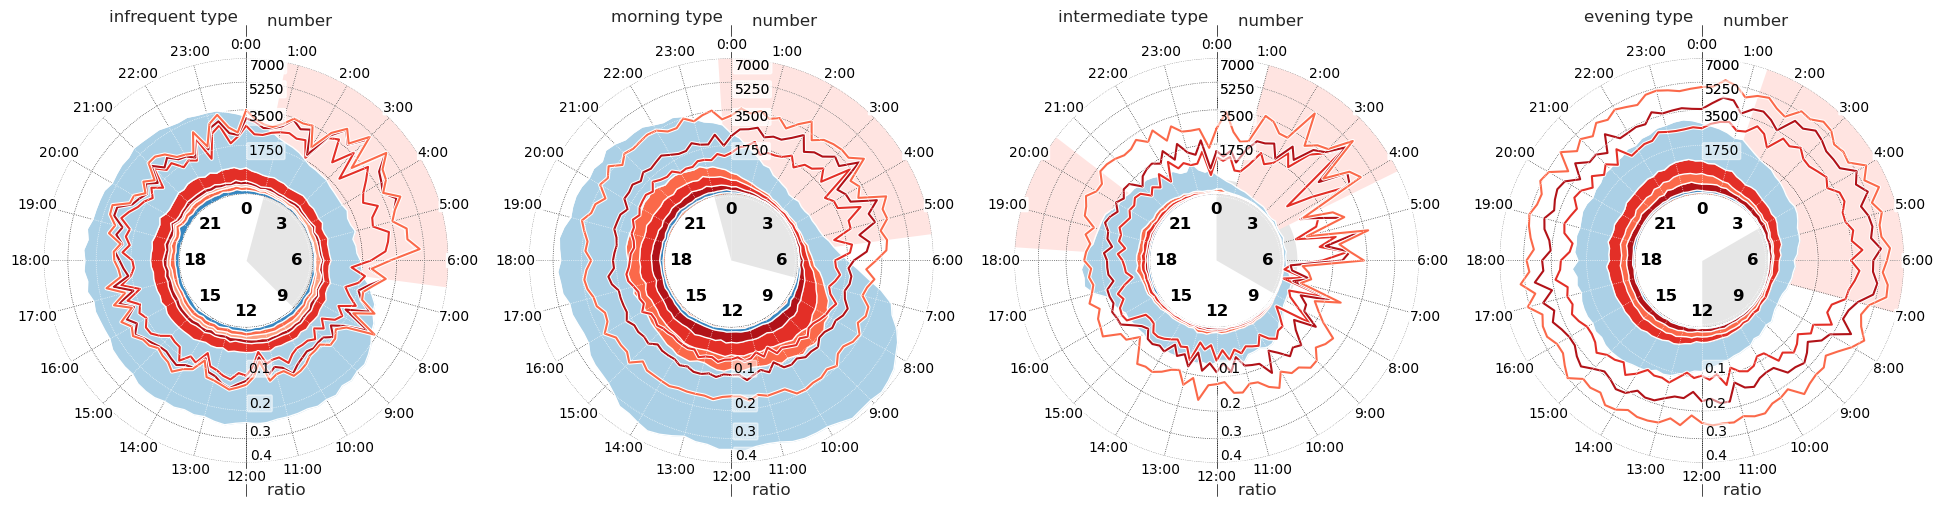

In [47]:
import matplotlib.font_manager
fig, axes = await sclockface.theme_circle_helper(
    df=by_cluster_f_time.rename(columns={
        Columns.NUM_POSTS.value: "    number",
        Columns.RATIO_BY_USER.value: "    ratio"
    }),
    usecols=["    number"],
    facet_col=Columns.CLUSTER.value,
    hue_col=Columns.FACTTYPE.value,
    palette=FactTypes.palette(),
    susceptible_df=ratio_smoothed[ratio_col].unstack(level=Columns.CLUSTER.value),
    facetorder=list(Clusters),
    perline=4,  mul=6,
    waking_times=waking_times,
    susceptible_kwargs=dict(quantile=0.25, window_size=8, pad_by=4, std=3, n=4),
    bar_func=sclockface.simple_area_stack,
    line_col=f'    ratio',
    share_h=True,
    project_area=True,
    line_order=[i.value.name for i in FactTypes.harmful_order()])


/data/estockinger/code/scripts/clockface_plots.py:77: RuntimeWarning: invalid value encountered in sqrt
  return ((value + v_offset) * alpha) ** 0.5 + r_offset
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/data/estockinger/code/scripts/clockface_plots.py:77: RuntimeWarning: invalid value encountered in sqrt
  return ((value + v_offset) * alpha) ** 0.5 + r_offset
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/data/estockinger/code/scripts/clockface_plots.py:77: RuntimeWarning: invalid value encountered in sqrt
  return ((value + v_offset) * alpha) ** 0.5 + r_offset
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/data/estockinger/code/scripts/clockface_plots.py:77: RuntimeWarning: invalid value encountered in sqrt
  return ((value + v_offset) * alpha) ** 0.5 + r_offset
The PostScript backend does not s

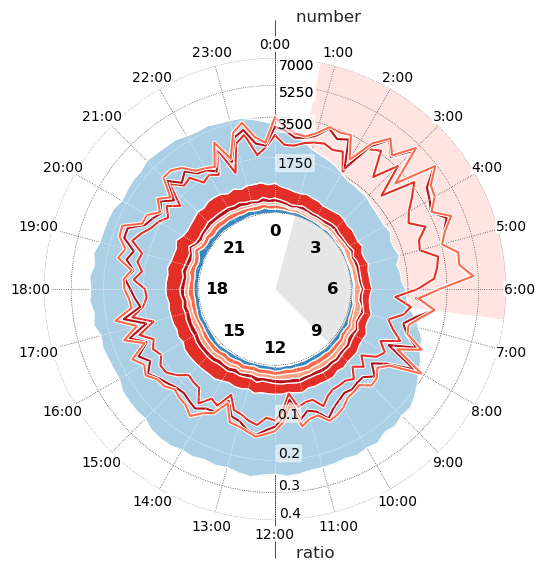

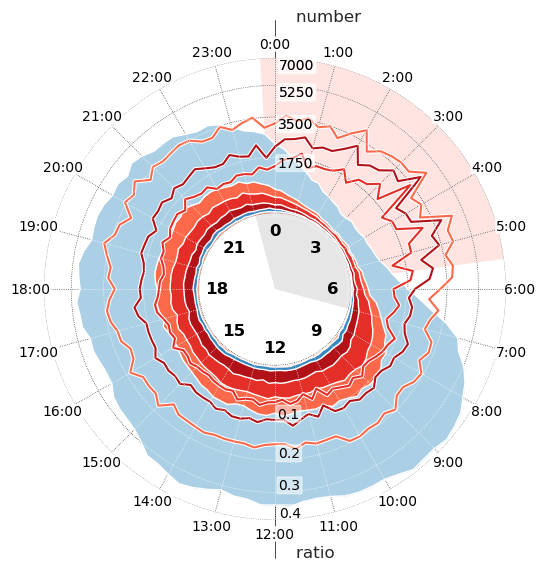

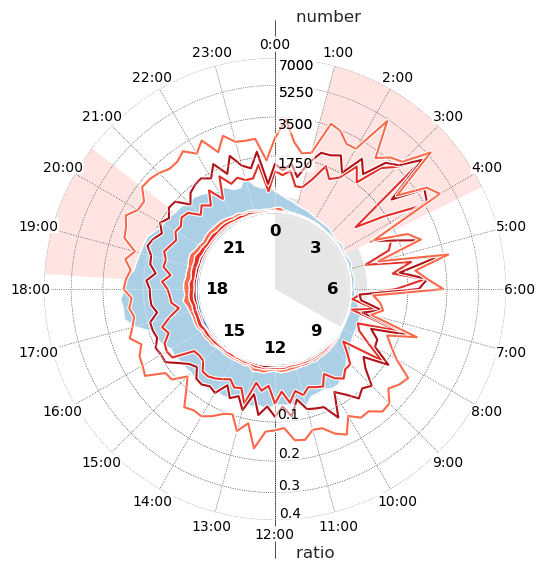

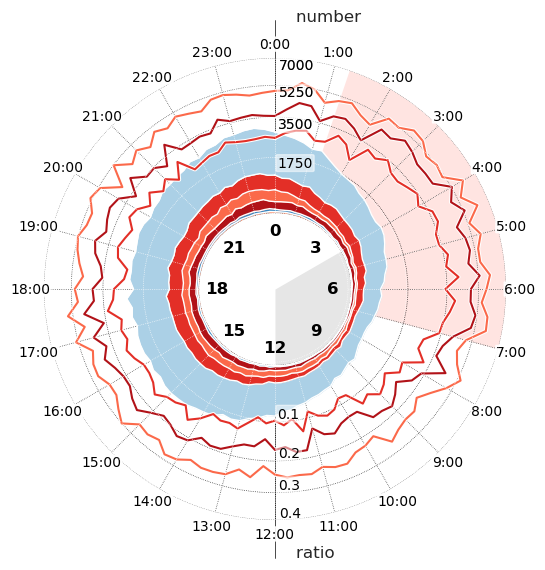

In [48]:
for c in Clusters:
    fig, axes = await sclockface.theme_circle_helper(
        df=by_cluster_f_time.rename(columns={
            Columns.NUM_POSTS.value: "    number",
            Columns.RATIO_BY_USER.value: "    ratio"
        }),
        usecols=["    number"],
        facet_col=Columns.CLUSTER.value,
        hue_col=Columns.FACTTYPE.value,
        palette=FactTypes.palette(),
        susceptible_df=ratio_smoothed[ratio_col].unstack(level=Columns.CLUSTER.value),
        facetorder=[c],
        perline=1,  mul=6,
        waking_times=waking_times,
        susceptible_kwargs=dict(quantile=0.25, window_size=8, pad_by=4, std=3, n=4),
        bar_func=sclockface.simple_area_stack,
        line_col=f'    ratio',
        share_h=True,
        project_area=True,
        title=False,
        line_order=[i.value.name for i in FactTypes.harmful_order()])
    fig.savefig(f"{config.SAVE_ROOT_DIR}clockface/{country_config.LABEL}/{c.split()[0]}_{TYPE}.eps", dpi=300, transparent=False)


Above we see:
- as a stackplot: the cumulative number of posts where reliability is known throughout the day, sorted by the  amount of posts of the type throughout the day.
- as a lineplot: with intermittent hatching the  **cumulative ratios** of potentially machinated content types (weighted by 1/num posts per user)
- within the inner shaded grey area: the time when users typically asleep
- within the red shaded background areas the times where the ratio of harmful posts is highest (red, 4th quantile)

Generally, infrequent types have lowest ratios of potentially machinated content types. Evening type individuals post higher baseline rates of potentially machinated content.

In [25]:
by_cluster_f_time_all = sprocessing.group_by_with_total(
    processor.all, group_by_cols=[Columns.MIN_BINS15, Columns.FACTTYPE, Columns.CLUSTER], ratio_for_idx=1)

/data/estockinger/code/scripts/clockface_plots.py:77: RuntimeWarning: invalid value encountered in sqrt
  return ((value + v_offset) * alpha) ** 0.5 + r_offset
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


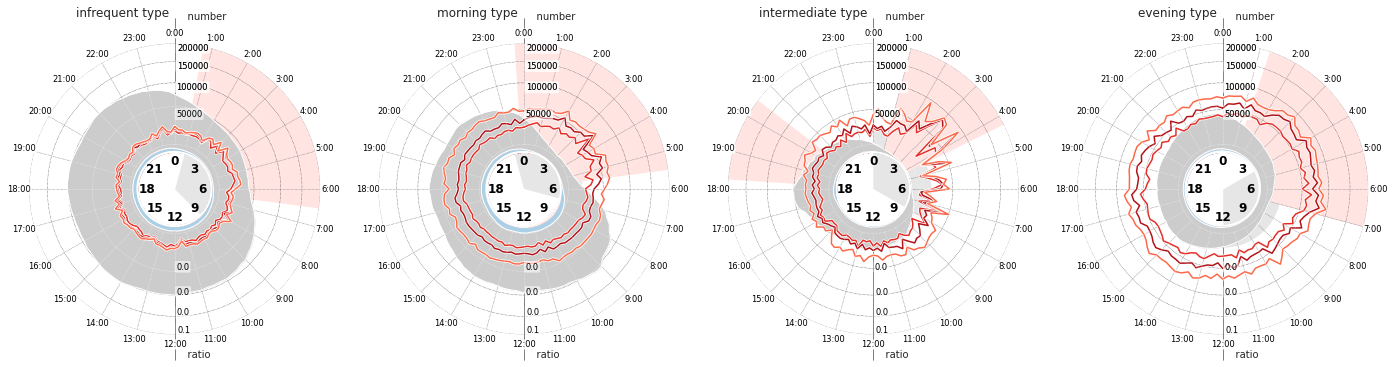

In [28]:
fig, axes = await sclockface.theme_circle_helper(
    df=by_cluster_f_time_all.rename(columns={
        Columns.NUM_POSTS.value: "    number",
        Columns.RATIO_BY_USER.value: "    ratio"
    }),
    usecols=["    number"],
    facet_col=Columns.CLUSTER.value,
    hue_col=Columns.FACTTYPE.value,
    palette=FactTypes.palette(),
    susceptible_df=ratio_smoothed[ratio_col].unstack(level=Columns.CLUSTER.value),
    facetorder=list(Clusters),
    perline=4,  mul=6, # the higher, the smaller font sizes
    waking_times=waking_times,
    susceptible_kwargs=dict(quantile=0.25, window_size=8, pad_by=4, std=3, n=4),
    bar_func=sclockface.simple_area_stack,
    line_col=f'    ratio',
    share_h=True,
    project_area=True,
    line_order=[i.value.name for i in FactTypes.harmful_order()])

# Lockdown and harmful content

In [29]:
processor.all[Columns.LOCKDOWN.value] = (('2020-03-09' <= processor.all[Columns.LOCAL_TIME.value]) & (processor.all[Columns.LOCAL_TIME.value] <= '2020-05-18'))
# | (('2020-11-05' <= sp.df['local_time']) & (sp.df['local_time'] <= '2020-12-01'))
h_during_lockdown=sprocessing.group_by_with_total(
    processor.all.loc[type_mask & known_mask],
    group_by_cols=[Columns.MIN_BINS15, Columns.LOCKDOWN, Columns.CLUSTER, Columns.MACHINATED],
    total_for_idx=-2)

In [30]:
processor.all[Columns.EMERGENCY.value] = (('2020-01-31' <= processor.all[Columns.LOCAL_TIME.value]) & (processor.all[Columns.LOCAL_TIME.value] <= '2022-03-31'))
h_during_emergency=sprocessing.group_by_with_total(
    processor.all.loc[type_mask & known_mask],
    group_by_cols=[Columns.MIN_BINS15, Columns.EMERGENCY, Columns.CLUSTER, Columns.MACHINATED],
    total_for_idx=-2)

In [31]:
statdf_covid=pd.DataFrame(0, index=list(Clusters)+['total'], columns=pd.MultiIndex.from_product(((Columns.LOCKDOWN.value, Columns.EMERGENCY.value), ['Statistic', 'P-Value'])))

for c in statdf_covid.index:
    tmp_df = h_during_lockdown.xs((c, True), level=(Columns.CLUSTER.value, Columns.MACHINATED.value))[ratio_col]
    stat,p = stats.mannwhitneyu(tmp_df.xs(True, level=Columns.LOCKDOWN.value), tmp_df.xs(False, level="in_lockdown"), alternative='less')
    statdf_covid.loc[c, Columns.LOCKDOWN.value] = stat,p
    tmp_df = h_during_emergency.xs((c, True), level=(Columns.CLUSTER.value, Columns.MACHINATED.value))[ratio_col]
    stat,p = stats.mannwhitneyu(tmp_df.xs(True, level=Columns.EMERGENCY.value), tmp_df.xs(False, level="emergency"), alternative='less')
    statdf_covid.loc[c, Columns.EMERGENCY.value] = stat,p

In [32]:
statdf_covid

in_lockdown               emergency              
                    Statistic       P-Value Statistic       P-Value
infrequent type          3587  4.016754e-03      3070  3.254980e-05
morning type             1390  3.212006e-17      1732  4.044739e-14
intermediate type        2451  2.828376e-07      3292  9.270035e-03
evening type             3506  2.111212e-03      4087  8.819524e-02
total                    3587  4.016754e-03      3070  3.254980e-05

In [33]:
lockdown_df = sprocessing.group_by_with_total(
    processor.all.loc[type_mask & known_mask],
    group_by_cols=[Columns.CLUSTER, Columns.MACHINATED, Columns.LOCKDOWN],
    total_for_idx=0,
    ratio_for_idx=1)

In [34]:
users_per_cluster = processor.all.loc[type_mask & known_mask].groupby([Columns.CLUSTER.value])[Columns.USER.value].nunique()
users_per_cluster['total']=users_per_cluster.sum()
users_per_cluster

cluster
evening type           2764
infrequent type      117284
intermediate type      1167
morning type           5904
total                127119
Name: User, dtype: int64

In [35]:
lockdown_days= { 
    True: len(processor.all.loc[type_mask & known_mask & (processor.all[Columns.LOCKDOWN.value]), Columns.LOCAL_TIME.value].dt.date.unique()),
    False: len(processor.all.loc[type_mask & known_mask & ~(processor.all[Columns.LOCKDOWN.value]), Columns.LOCAL_TIME.value].dt.date.unique())
}
def posts_per_day(x, row, num_users=None):
    cluster, lockdown = row.name
    return row[x]/lockdown_days[lockdown]/(1 if num_users is None else num_users[cluster])

In [36]:
lockdown_stat_df = (lockdown_df
    .loc[lockdown_df.index.get_level_values(level=Columns.LOCKDOWN.value)!="total"]
    .xs(True, level=Columns.MACHINATED.value)[[Columns.RATIO_BY_USER.value, Columns.NUM_POSTS.value]])
lockdown_stat_df['num_posts_total'] = num_posts_by_lockdown=lockdown_df.groupby(level=[Columns.CLUSTER.value, Columns.LOCKDOWN.value])[Columns.NUM_POSTS.value].sum()
lockdown_stat_df["posts_per_day_and_user"]=lockdown_stat_df.apply(lambda row: posts_per_day(Columns.NUM_POSTS.value, row, users_per_cluster), axis=1)
lockdown_stat_df["harmful_posts_per_day_and_user"]=lockdown_stat_df.apply(lambda row: posts_per_day('num_posts_total', row, users_per_cluster), axis=1)
lockdown_stat_df = lockdown_stat_df[[Columns.RATIO_BY_USER.value, 'harmful_posts_per_day_and_user', 'posts_per_day_and_user']].unstack(level=1)
for i in [Columns.RATIO_BY_USER.value, 'harmful_posts_per_day_and_user', 'posts_per_day_and_user']:
    lockdown_stat_df[i, 'diff']= lockdown_stat_df[i, True] - lockdown_stat_df[i, False]
lockdown_stat_df.sort_index(axis=1, inplace=True)
lockdown_stat_df.columns=pd.MultiIndex.from_product(((f'{ContentType.MANIPULATED.value} posts/day/user','posts/day/user', f'ratio of {ContentType.MANIPULATED.value} content'),('no lockdown', 'lockdown', 'change')))
lockdown_stat_df.index.name=None
lockdown_stat_df.T

evening type  \
potentially machinated posts/day/user   no lockdown      0.063501   
                                        lockdown         0.109097   
                                        change           0.045596   
posts/day/user                          no lockdown      0.021076   
                                        lockdown         0.033761   
                                        change           0.012685   
ratio of potentially machinated content no lockdown      0.283071   
                                        lockdown         0.262110   
                                        change          -0.020961   

                                                     infrequent type  \
potentially machinated posts/day/user   no lockdown         0.002646   
                                        lockdown            0.006573   
                                        change              0.003927   
posts/day/user                          no lockdown         0.000438   
                                        lockdown            0.000921   
                                        change              0.000483   
ratio of potentially machinated content no lockdown         0.149550   
                                        lockdown            0.127973   
                                        change             -0.021577   

                                                     intermediate type  \
potentially machinated posts/day/user   no lockdown           0.082961   
                                        lockdown              0.104823   
                                        change                0.021863   
posts/day/user                          no lockdown           0.011433   
                                        lockdown              0.011531   
                                        change                0.000099   
ratio of potentially machinated content no lockdown           0.149844   
                                        lockdown              0.108386   
                                        change               -0.041458   

                                                     morning type     total  
potentially machinated posts/day/user   no lockdown      0.065944  0.007646  
                                        lockdown         0.116236  0.014798  
                                        change           0.050292  0.007151  
posts/day/user                          no lockdown      0.015715  0.001697  
                                        lockdown         0.019817  0.002610  
                                        change           0.004102  0.000913  
ratio of potentially machinated content no lockdown      0.187602  0.149600  
                                        lockdown         0.140071  0.128001  
                                        change          -0.047531 -0.021599

In [37]:
lockdown_contingency=processor.all.loc[type_mask & known_mask].groupby([Columns.MACHINATED.value, Columns.LOCKDOWN.value])[Columns.TWEET_ID.value].count().unstack(level=1)

In [38]:
stats.chi2_contingency(lockdown_contingency)

(1395.5570486235006,
 1.9404074016849037e-305,
 1,
 array([[651002.58721491, 103268.41278509],
        [179068.41278509,  28405.58721491]]))

In [39]:
activity_path_manager.to_latex(
    lockdown_stat_df.T[list(Clusters)].style.format('{:.3f}', na_rep="-"),
    'stats_lockdown',
    caption=r"Number of posts and ratio of harmful content during and outside of the lockdown period.",
    is_multi_index=True
)

# Sunlight impacts a user's spreading of disinformation

In [9]:
m_over_time = sprocessing.group_by_with_total(
    processor.all.loc[type_mask & known_mask & (processor.all[Columns.LOCAL_TIME.value] < '2022-08-01')],
    group_by_cols = [Columns.YEAR, Columns.MONTH, Columns.MIN_BINS15, Columns.MACHINATED, Columns.CLUSTER],
    ratio_for_idx=-2, total_for_idx=-1,
    aggregate_cols=[Columns.LAT, Columns.LONG]
)

In [10]:
df_monthly = m_over_time.xs('total', level=Columns.CLUSTER.value)

In [11]:
from suntime import Sun
import datetime, pytz, math

lat = df_monthly[Columns.LAT.value].mean()
long = df_monthly[Columns.LONG.value].mean()
sun = Sun(lat, long)
tz = pytz.timezone(country_config.TIME_ZONE)

def to_bin(timeobj):
    timeobj = timeobj.time()
    return (((timeobj.hour*3600)+(timeobj.minute*60))//900)*0.25


sun_times = {}
for i in range(1,13):
    date = datetime.date(2020, i, 1)
    sunrise = sun.get_local_sunrise_time(date, local_time_zone=tz)
    sun_times[i] = {
        "sunrise":  to_bin(sun.get_local_sunrise_time(date, local_time_zone=tz)),
        "sunset":  to_bin(sun.get_local_sunset_time(date, local_time_zone=tz))
    }

sun_times = pd.DataFrame.from_dict(sun_times, orient='index')
years_spanned = math.ceil(np.ptp(processor.all.loc[type_mask, Columns.LOCAL_TIME.value]).days/365)
sun_times_total = pd.concat([sun_times for _ in range(years_spanned)]).reset_index(drop=True)
daytimes=round(sun_times_total.mean()*4)/4

In [12]:
daytimes

sunrise     6.50
sunset     18.75
dtype: float64

In [13]:
palette=["lightblue", "coral", "darkred"]
cmap=sns.color_palette("blend:"+",".join(palette), as_cmap=True)

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


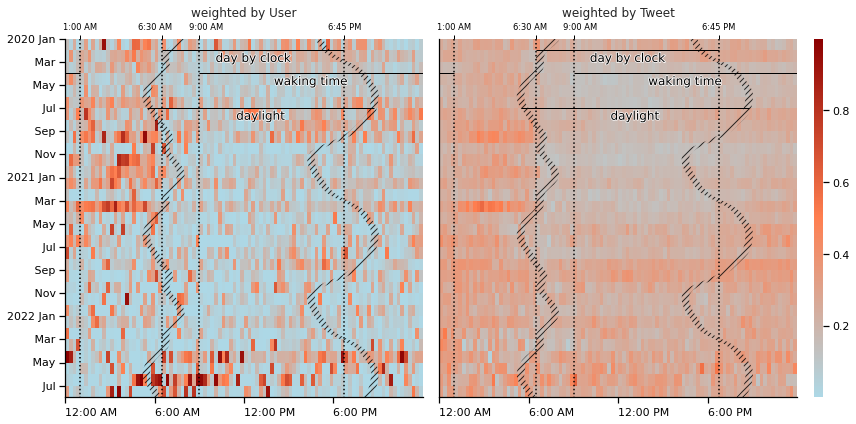

In [14]:
import matplotlib.font_manager
cols=[Columns.RATIO_BY_USER.value, Columns.RATIO_BY_TWEET.value]
sheatmap.plot_heatmap_facets(
    m_over_time.xs((True, 'total'), level=(Columns.MACHINATED.value, Columns.CLUSTER.value))[cols],
    sun_times=sun_times_total, waking_times={c: waking_times['total'] for c in cols}, day_times=daytimes,
    columns=cols, subtitles=["weighted by User", "weighted by Tweet"], figsize=(12,6), cmap=cmap, edgecolor="black");

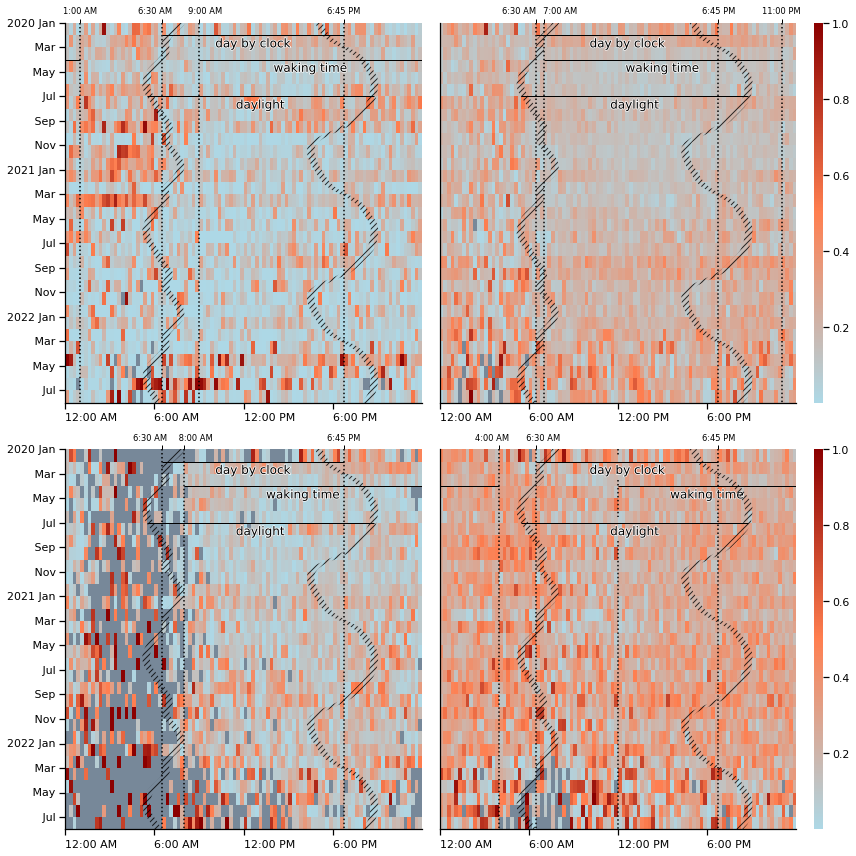

In [15]:
fig, axes = sheatmap.plot_heatmap_facets(
    m_over_time.xs(True, level=Columns.MACHINATED.value)[Columns.RATIO_BY_USER.value].unstack(level=Columns.CLUSTER.value),
    sun_times=sun_times_total, waking_times={i:waking_times[i] for i in Clusters}, day_times=daytimes,
    columns=list(Clusters), subtitles = [],
    figsize=(12,12), cmap=cmap, facecolor='lightslategrey', nrows=2, ncols=2, edgecolor="black")

In [16]:
bbox_for_cluster = {
    # left, bottom, right, top
    'infrequent': (0,6,6,12),
    'morning': (6,6,12,12),
    'intermediate': (0,0,6,6),
    'evening': (6,0,12,6)
}
for c, b in bbox_for_cluster.items():
    fig.savefig(f"{config.SAVE_ROOT_DIR}heatmap/{country_config.LABEL}/{c}_{TYPE}.eps", dpi=300, transparent=False, bbox_inches=mpl.transforms.Bbox.from_extents(b))

### By FactType

In [17]:
f_over_time = sprocessing.group_by_with_total(
    processor.all.loc[type_mask &  known_mask & (processor.all[Columns.LOCAL_TIME.value] < '2022-08-01')],
    group_by_cols = [Columns.YEAR, Columns.MONTH, Columns.MIN_BINS15, Columns.FACTTYPE, Columns.CLUSTER],
    ratio_for_idx=-2, total_for_idx=-1
)

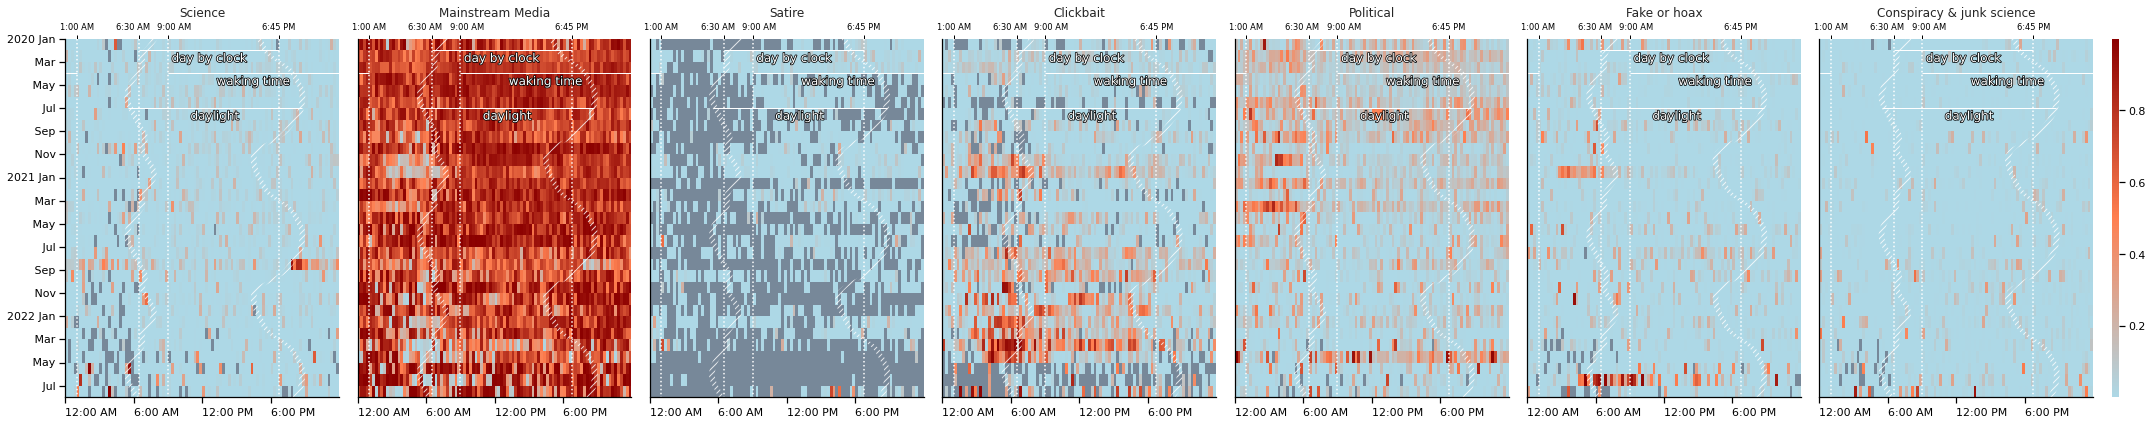

In [18]:
fig, axes = sheatmap.plot_heatmap_facets(
    f_over_time.xs('total', level=Columns.CLUSTER.value)['ratio_norm'].unstack(level=sconstants.f_col),
    sun_times=sun_times_total, waking_times={i:waking_times['total'] for i in FactTypes.known_order('name')}, day_times=daytimes,
    columns=FactTypes.known_order('name'), subtitles = FactTypes.known_order('name'),
    figsize=(30,6), cmap=cmap, facecolor='lightslategrey', nrows=1, ncols=7)

### Statistics

In [19]:
sday.get_waking_time(m_over_time, daytimes, waking_times, sun_times_total, safety_margin=(1,1))
sday.get_waking_time(f_over_time, daytimes, waking_times, sun_times_total, safety_margin=(1,1))

In [20]:
for c in Clusters:
    tmpdf=m_over_time.xs((True, c), level=(Columns.MACHINATED.value, Columns.CLUSTER.value))[Columns.RATIO_BY_USER.value]
    print(f'{c}: {stats.shapiro(tmpdf)}')

infrequent type: ShapiroResult(statistic=0.804177463054657, pvalue=0.0)
morning type: ShapiroResult(statistic=0.8943783640861511, pvalue=3.994401272557891e-41)
intermediate type: ShapiroResult(statistic=0.7946950793266296, pvalue=0.0)
evening type: ShapiroResult(statistic=0.9517737030982971, pvalue=4.944005859671479e-30)


Our data is not normally distributed.

In [21]:
shared_args = {
    'ratio_col': Columns.RATIO_BY_USER.value,
    'test': stats.mannwhitneyu,
}
m_stat_df = sday.pair_cols(m_over_time, Columns.MACHINATED.value, ivals=[True], **shared_args)
f_stat_df = sday.pair_cols(f_over_time, Columns.FACTTYPE.value, ivals=FactTypes.harmful_order('name'), **shared_args)

Find which distribution was lower (day or night) only for those values where p was significant:

In [22]:
threshold=.05
stat_df = pd.concat([
        sday.find_distribution_side(m_stat_df, threshold=threshold).rename(index={True: ContentType.MANIPULATED.value}),
        sday.find_distribution_side(f_stat_df, threshold=threshold).loc[FactTypes.harmful_order('name')]
    ])

In [23]:
stat_df_style =(
    stat_df.loc[stat_df.index.get_level_values(1).isin(list(Clusters))]
    .rename(columns={
        'daytime': r'6:30am - 6:45pm\tnote{1}',
        'suntime': r'sunrise - sunset\tnote{2}',
        'waking_time': r'waking - bedtime\tnote{3}'
    })
    .style
    .format('{:,.0f}', subset=pd.IndexSlice[:, pd.IndexSlice[:, "Statistic"]])
    .format('{:.1e}', subset=pd.IndexSlice[:, pd.IndexSlice[:, "P-Value"]])
    .applymap(
        lambda v: 'font-weight: bold;' if (v < 0.05) else None,
        subset=pd.IndexSlice[:, pd.IndexSlice[:, "P-Value"]])
)
stat_df_style

In [24]:
activity_path_manager.to_latex(
    stat_df_style,
    'mannwhitneyu_daysunwaking',
    caption=r"One-sided Mann-Whitney U test indicating whether the distribution of ratios of \harmful{} content throughout the day (see \autoref{fig:fourier_activity_clocktime}) underlying one cluster (rows) is smaller than that of another cluster (columns).",
    is_multi_index=True
)